# Process the gravity data



In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from fatiando.gravmag import normal_gravity
from load_icgem import load_icgem_gdf

In [2]:
data = load_icgem_gdf('data/go_cons_gcf_2_tim_r5-africa-1deg.gdf')

In [3]:
data.keys()

['area', 'longitude', 'height', 'shape', 'latitude', 'gravity_ell', 'metadata']

In [4]:
print(data['metadata'])

generating_institute     gfz-potsdam
     generating_date     2016/07/12
        product_type     gravity_field
                body     earth
           modelname     go_cons_gcf_2_tim_r5
     max_used_degree           280
         tide_system     tide_free
          functional     gravity_ell  (centrifugal term included)
                unit     mgal
          refsysname     WGS84
            gmrefpot      3.98600441800E+14 m**3/s**2
        radiusrefpot     6378137.000 m
          flatrefpot      3.352810664747480E-03   (1/298.25722356300)
         omegarefpot      7.29211500000E-05 1/s
       long_lat_unit     degree
      latlimit_north       40.000000000000    
      latlimit_south      -40.000000000000    
      longlimit_west      -20.000000000000    
      longlimit_east       55.000000000000    
            gridstep       1.0000000000000    
     height_over_ell       4000.0000 m
  latitude_parallels            81
 longitude_parallels            76
number_of_gridpoints       

In [5]:
lat = data['latitude']
lon = data['longitude']
height = data['height']
grav = data['gravity_ell']
shape = data['shape']
area = data['area']

In [6]:
print(area)

[-40.0, 40.0, -20.0, 55.0]


To choose colormaps:

* http://matplotlib.org/examples/color/colormaps_reference.html
* http://matplotlib.org/users/colormaps.html

(-20.0, 55.0)

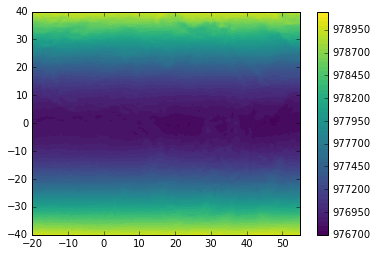

In [7]:
plt.figure()
plt.tricontourf(lon, lat, grav, 50, cmap='viridis')
plt.colorbar()
plt.xlim(area[2], area[3])

In [8]:
gammap = normal_gravity.gamma_closed_form(lat, height)

(-20.0, 55.0)

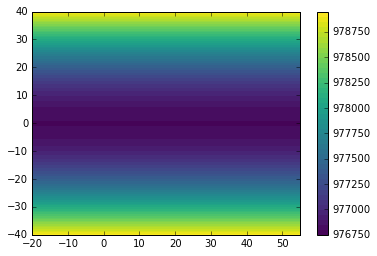

In [9]:
plt.figure()
plt.tricontourf(lon, lat, gammap, 50, cmap='viridis')
plt.colorbar()
plt.xlim(area[2], area[3])

The disturbance is the difference between the observed gravity and the normal gravity at the same point:

$$
\delta(P) = g(P) - \gamma(P)
$$

In [10]:
disturbance = grav - gammap

(-20.0, 55.0)

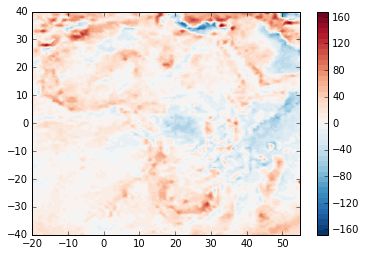

In [11]:
plt.figure()
plt.tricontourf(lon, lat, disturbance, 50, cmap='RdBu_r')
plt.colorbar()
plt.xlim(area[2], area[3])

In [12]:
etopo = load_icgem_gdf('data/etopo1-africa-1deg.gdf')

In [13]:
etopo.keys()

['area', 'longitude', 'shape', 'topography_grd', 'latitude', 'metadata']

In [14]:
topo = etopo['topography_grd']

(-20.0, 55.0)

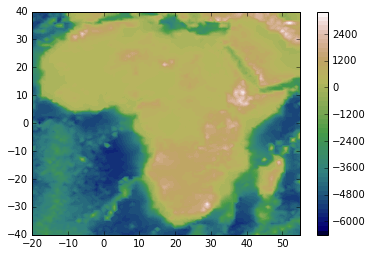

In [15]:
plt.figure()
plt.tricontourf(lon, lat, topo, 50, cmap='gist_earth')
plt.colorbar()
plt.xlim(area[2], area[3])

In [16]:
bouguer = disturbance - normal_gravity.bouguer_plate(topo)

(-20.0, 55.0)

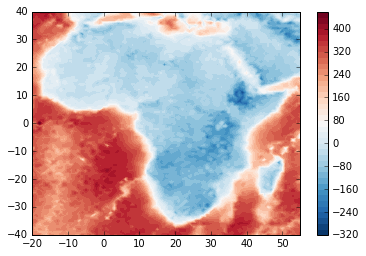

In [17]:
plt.figure()
plt.tricontourf(lon, lat, bouguer, 50, cmap='RdBu_r')
plt.colorbar()
plt.xlim(area[2], area[3])

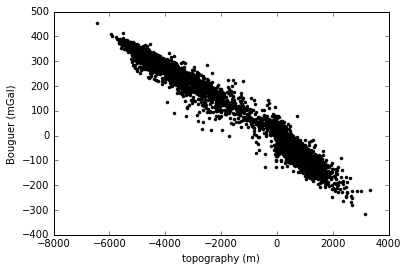

In [18]:
plt.figure()
plt.plot(topo, bouguer, '.k')
plt.xlabel('topography (m)')
plt.ylabel('Bouguer (mGal)')